
=== Model Performance ===
vitamin_d             R²: 0.202    RMSE: 21.870
hdl_cholesterol       R²: 0.229    RMSE: 14.346
a1c                   R²: 0.149    RMSE: 0.976


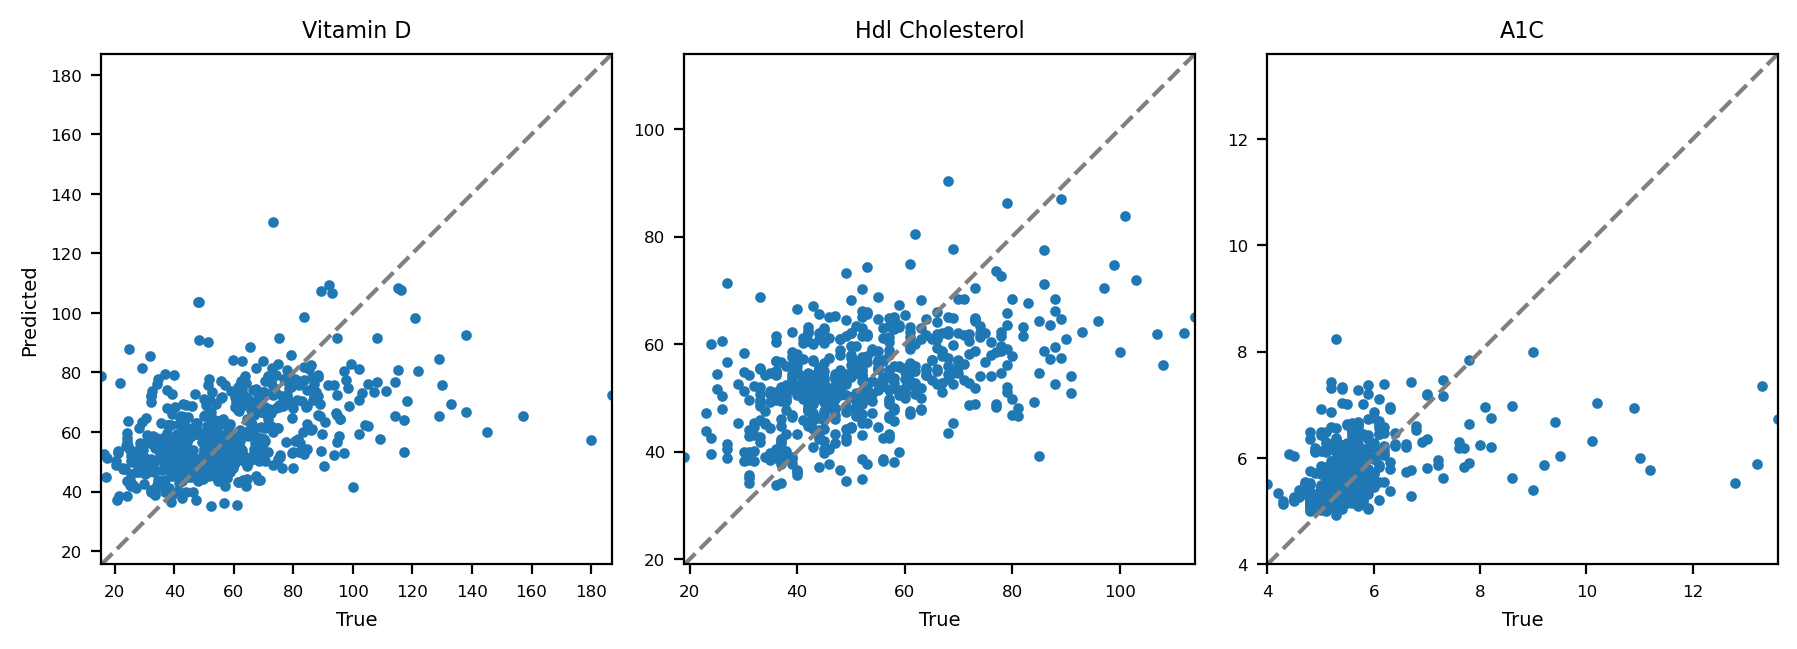


✅ Model saved to: ../models/baseline_rf_model.pkl


In [2]:
# === 1. Imports & Plot Settings ===
import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

# === Global Plot Config ===
plt.rcParams.update({
    'figure.dpi': 200,
    'savefig.dpi': 300,
    'font.size': 7,
    'axes.labelsize': 7,
    'axes.titlesize': 8,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 6,
    'axes.grid': False
})

# === 2. Load cleaned dataset and metadata ===
df = pd.read_feather("../data/processed/cleaned_nhanes.feather")
with open("../data/processed/metadata.json") as f:
    meta = json.load(f)

target_cols = meta["target_cols"]
cat_features = meta["cat_features"]
num_features = meta["num_features"]

assert df[target_cols].notnull().all().all(), "❌ Unexpected NaNs in target columns!"

# === 3. Split features and targets ===
X = df.drop(columns=target_cols)
y = df[target_cols]

# === 4. Train/Test split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === 5. Preprocessing pipelines ===
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_features),
    ('cat', categorical_pipeline, cat_features)
])

# === 6. Full modeling pipeline ===
model = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', MultiOutputRegressor(RandomForestRegressor(random_state=42)))
])

# === 7. Fit model ===
model.fit(X_train, y_train)

# === 8. Evaluate on test set ===
y_pred = model.predict(X_test)

print("\n=== Model Performance ===")
for i, col in enumerate(target_cols):
    r2 = r2_score(y_test[col], y_pred[:, i])
    rmse = mean_squared_error(y_test[col], y_pred[:, i], squared=False)
    print(f"{col:<20}  R²: {r2:.3f}    RMSE: {rmse:.3f}")

# === 9. Diagnostic scatter plots (horizontal subplots, 1:1 range) ===
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

for i, col in enumerate(target_cols):
    ax = axes[i]
    true_vals = y_test[col]
    pred_vals = y_pred[:, i]

    # Compute common axis range
    min_val = min(true_vals.min(), pred_vals.min())
    max_val = max(true_vals.max(), pred_vals.max())

    # Scatter plot
    ax.scatter(true_vals, pred_vals, alpha=1, s=8)
    ax.plot([min_val, max_val], [min_val, max_val], '--', color='gray')

    # Labels and formatting
    ax.set_title(col.replace('_', ' ').title(), fontsize=8)
    ax.set_xlabel("True")
    if i == 0:
        ax.set_ylabel("Predicted")
    else:
        ax.set_ylabel("")
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_aspect('equal', 'box')
    ax.tick_params(axis='both', labelsize=6)

plt.tight_layout()
plt.show()

# === 10. Save model ===
os.makedirs("../models", exist_ok=True)
joblib.dump(model, "../models/baseline_rf_model.pkl")
print("\n✅ Model saved to: ../models/baseline_rf_model.pkl")



=== Linear Regression Performance ===
vitamin_d             R²: 0.253    RMSE: 21.168
hdl_cholesterol       R²: 0.210    RMSE: 14.522
a1c                   R²: 0.183    RMSE: 0.956


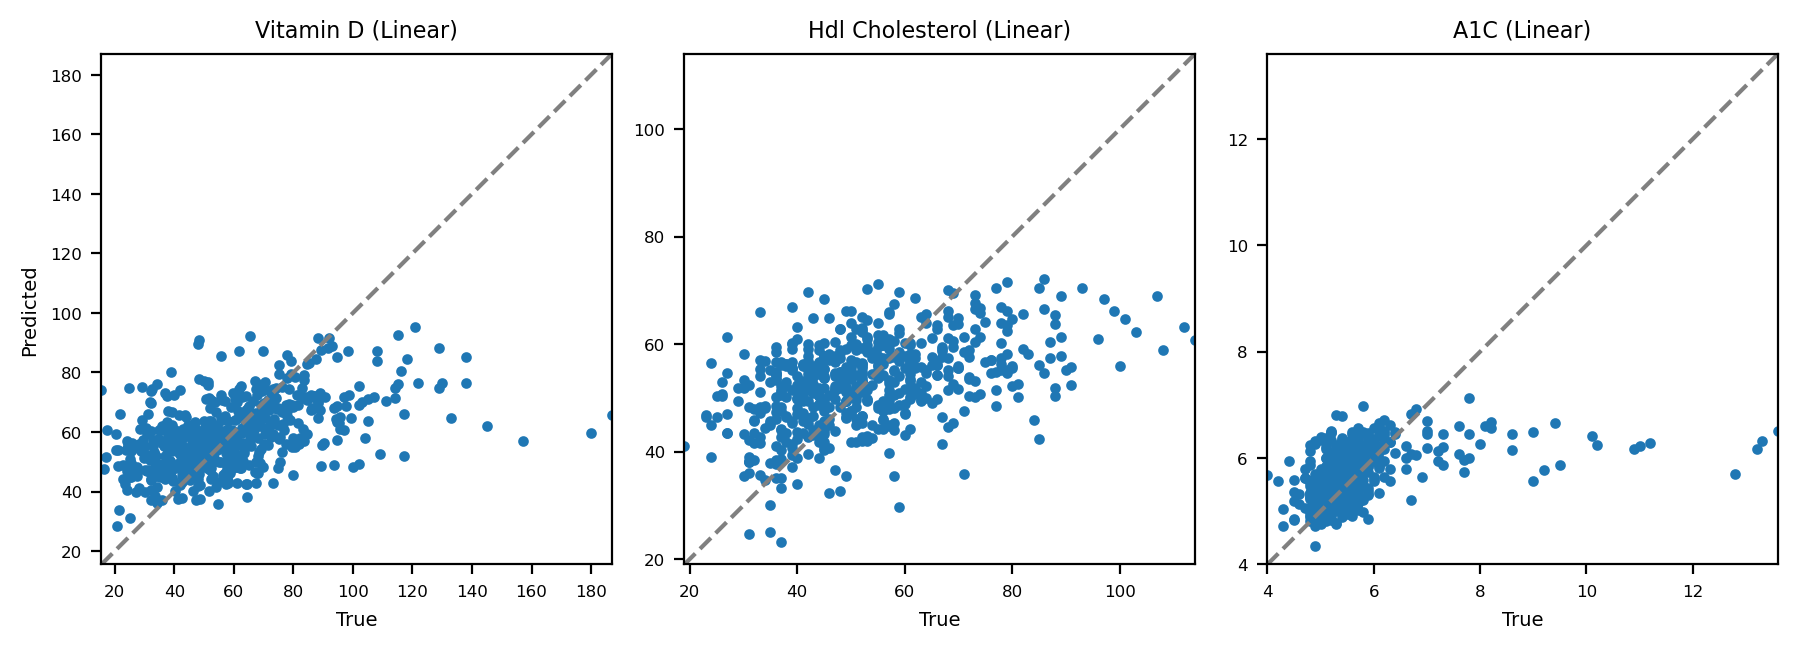

In [3]:
# === Linear model pipeline ===
linear_model = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', MultiOutputRegressor(LinearRegression()))
])

linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

print("\n=== Linear Regression Performance ===")
for i, col in enumerate(target_cols):
    r2 = r2_score(y_test[col], y_pred_linear[:, i])
    rmse = mean_squared_error(y_test[col], y_pred_linear[:, i], squared=False)
    print(f"{col:<20}  R²: {r2:.3f}    RMSE: {rmse:.3f}")

# === Diagnostic scatter plots for Linear Regression ===
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

for i, col in enumerate(target_cols):
    ax = axes[i]
    true_vals = y_test[col]
    pred_vals = y_pred_linear[:, i]

    # Consistent min/max across all targets
    min_val = min(true_vals.min(), pred_vals.min())
    max_val = max(true_vals.max(), pred_vals.max())

    # Scatter plot
    ax.scatter(true_vals, pred_vals, alpha=1, s=8)
    ax.plot([min_val, max_val], [min_val, max_val], '--', color='gray')

    # Labels and formatting
    ax.set_title(col.replace('_', ' ').title() + " (Linear)", fontsize=8)
    ax.set_xlabel("True")
    if i == 0:
        ax.set_ylabel("Predicted")
    else:
        ax.set_ylabel("")
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_aspect('equal', 'box')
    ax.tick_params(axis='both', labelsize=6)

plt.tight_layout()
plt.show()



In [4]:
# === 1. Compute metrics ===

# Random Forest: training metrics
y_train_pred = model.predict(X_train)
rf_train_r2 = [r2_score(y_train[col], y_train_pred[:, i]) for i, col in enumerate(target_cols)]

# Random Forest: test metrics
rf_test_r2 = [r2_score(y_test[col], y_pred[:, i]) for i, col in enumerate(target_cols)]
rf_test_rmse = [mean_squared_error(y_test[col], y_pred[:, i], squared=False) for i, col in enumerate(target_cols)]

# Linear Regression: test metrics
lin_test_r2 = [r2_score(y_test[col], y_pred_linear[:, i]) for i, col in enumerate(target_cols)]
lin_test_rmse = [mean_squared_error(y_test[col], y_pred_linear[:, i], squared=False) for i, col in enumerate(target_cols)]

# === 2. Build summary DataFrame ===

metrics_df = pd.DataFrame({
    "Target": target_cols,
    "RF R² (train)": rf_train_r2,
    "RF R² (test)": rf_test_r2,
    "RF RMSE": rf_test_rmse,
    "Linear R²": lin_test_r2,
    "Linear RMSE": lin_test_rmse
}).round(3)

display(metrics_df)

# === 3. Save metrics JSON ===

metrics_dict = {
    target: {
        "rf": {
            "r2_train": rf_train_r2[i],
            "r2_test": rf_test_r2[i],
            "rmse": rf_test_rmse[i]
        },
        "linear": {
            "r2_test": lin_test_r2[i],
            "rmse": lin_test_rmse[i]
        }
    } for i, target in enumerate(target_cols)
}

os.makedirs("../models", exist_ok=True)

with open("../models/baseline_metrics.json", "w") as f:
    json.dump(metrics_dict, f, indent=2)
print("✅ Saved evaluation metrics to '../models/baseline_metrics.json'")

# === 4. Save metadata ===

model_info = {
    "model": "RandomForest",
    "version": "v0.1",
    "timestamp": datetime.now().isoformat(),
    "features": {
        "numerical": num_features,
        "categorical": cat_features
    },
    "targets": target_cols
}

with open("../models/model_metadata.json", "w") as f:
    json.dump(model_info, f, indent=2)
print("✅ Saved model metadata to '../models/model_metadata.json'")


,Target,RF R² (train),RF R² (test),RF RMSE,Linear R²,Linear RMSE
0,vitamin_d,0.884,0.202,21.870,0.253,21.168
1,hdl_cholesterol,0.887,0.229,14.346,0.210,14.522
2,a1c,0.880,0.149,0.976,0.183,0.956


✅ Saved evaluation metrics to '../models/baseline_metrics.json'
✅ Saved model metadata to '../models/model_metadata.json'
